In [1]:
import random
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [2]:
!gdown --id 1-GnWpEkyjLljI_UwPA47j6kgtzLYamFQ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-GnWpEkyjLljI_UwPA47j6kgtzLYamFQ
To: /content/parallel_data_SEM_CHILDES_3.csv
100% 71.7M/71.7M [00:00<00:00, 106MB/s]


In [3]:
childes = pd.read_csv("parallel_data_SEM_CHILDES_3.csv")

In [4]:
childes

,english,bliss
0,it's a chicken,14960 12639 8521 13165
1,what is that,18231 12639 16482
2,it's a woof,14960 12639 8521 -999999
3,is that a hat,12639 16482 8521 14682
4,oh look at that,16747 12591 16482
...,...,...
961773,it was something funny two things,14960 12639 12400 14414 8512 17717
961774,two things that were funny,8512 17717 16482 12639 14414
961775,nber two he bendeded a camp,-999999 8512 14687 -999999 8521 13112
961776,went into someone's face,14449 25896 12399 12639 14138


In [5]:

def percent_unidentified(x):
    d = x.strip().split(" ");
    den = len(d)
    num = d.count("-999999");
    return num/den

def clean_data(df):
    df.dropna(inplace = True)
    df["percent_unidentified"] = df["bliss"].apply(percent_unidentified)
    df = df[(df['percent_unidentified']<0.1)]
    # df = df.loc[df['english'].drop_duplicates(keep = "first").index]
    df["bliss"] = df["bliss"].apply(lambda x: x.strip())
    df = df.sample(frac = 1, random_state=43).reset_index(drop=True)

    return df

data  = clean_data(childes)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [6]:
data

,english,bliss,percent_unidentified
0,too small isn't it,12374 15221 12639 15733 14960,0.0
1,you got some cream cheese,18465 14435 17207 13605 13157,0.0
2,I'm gonna put the light on,14916 12639 14449 17739 16440 17700 25336 12324,0.0
3,you want the old spot,18465 24834 17700 15915 17236,0.0
4,"this is a microphone , and that's a microphone","17720 12639 8521 23902 , 12374 16482 12639 852...",0.0
...,...,...,...
584618,you don't want the whole thing or nothing do you,18465 13860 15733 24834 17700 12360 17717 1592...,0.0
584619,now you're using the screwdriver,15736 18465 12639 17991 17700 16740,0.0
584620,goes through where,14449 17724 18237,0.0
584621,this just goes on like this,17720 12363 14449 12324 16984 17720,0.0


In [7]:
len(data)


584623

In [8]:
text_pairs = [(data["english"][i], "[start] " + data["bliss"][i] + " [end]") for i in range(len(data))]


In [9]:
# random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

584623 total pairs
467699 training pairs
58462 validation pairs
58462 test pairs


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1265404927353186428
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13690463138429463803
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [11]:
import re
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


inp_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
out_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_inp_texts = [pair[0] for pair in train_pairs]
train_out_texts = [pair[1] for pair in train_pairs]
inp_vectorization.adapt(train_inp_texts)
out_vectorization.adapt(train_out_texts)

In [12]:

def format_dataset(inp_lang, out_lang):
    inpv = inp_vectorization(inp_lang)
    outv = out_vectorization(out_lang)
    return ({"encoder_inputs": inpv, "decoder_inputs": outv[:, :-1],}, outv[:, 1:])


def make_dataset(pairs):
    inp_texts, out_texts = zip(*pairs)
    inp_texts = list(inp_texts)
    out_texts = list(out_texts)
    dataset = tf.data.Dataset.from_tensor_slices((inp_texts, out_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [13]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [14]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [15]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [16]:
##LOAD SAVED MODEL

# from tensorflow import keras
# transformer = keras.models.load_model('/content/saved-model-05-0.11.hdf5', custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder':TransformerEncoder, 'TransformerDecoder':TransformerDecoder})

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
## TRAIN

epochs = 5  # This should be at least 30 for convergence
filepath = "/content/drive/MyDrive/btp/english_to_bliss-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=checkpoint)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

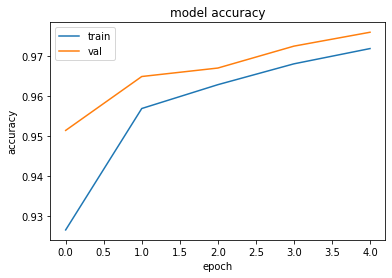

In [19]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

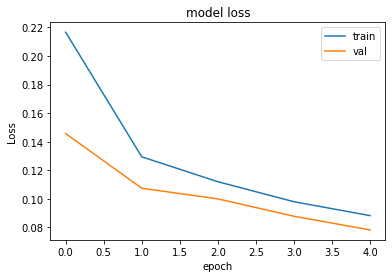

In [20]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
out_vocab = out_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_inp_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_inp_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)

, 14687 12639 12850 12374 18242 [start] hes black and white [end]
14449 14449 13869 [start] go go down [end]
14916 24732 14688 15942 [start] i let her out [end]
15722 , 14960 13860 15733 16728 15671 15671 [start] no it doesnt talk much much [end]
13114 18465 14449 13408 17714 14382 15662 [start] can you go cook them for mommy [end]
17207 21609 16440 12911 17453 15929 18242 17453 15929 14889 [start] some people put brown sugar or white sugar or honey [end]
12324 17700 26319 [start] on the movie [end]
14916 14179 17700 14666 [start] i found the hammer [end]
18231 12639 18212 14449 17739 16728 12324 [start] what are we going to talk about [end]
18465 13114 16747 17207 12663 17700 17269 [start] you can see some of the store [end]
24732 12639 13906 15733 13906 17982 18212 14435 17739 17700 17493 [start] lets eat not eat until we get to the table [end]
, 16482 12639 8521 17244 13121 [start] thats a pumpkin car [end]
14916 14685 8521 14889 12875 [start] i have a honey book [end]
18465 14435 1

In [ ]:
input_sentence ='13860 '
translated = decode_sequence(input_sentence)
print(input_sentence, translated)

13860  [start] xxx do [end]


In [ ]:
for _ in range(30):
    input_sentence = random.choice(test_inp_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)

15929 24017 12639 12390 [start] or theres animals [end]
14916 14435 17193 12643 12324 14960 [start] i got [end]
13616 14960 [start] xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx xxx [end]
14916 22914 14685 8521 14413 16209 13860 15733 14916 [start] i must have a full pocket dont i [end]
14960 13383 12602 17700 25433 [start] it comes off the oh xxx [end]
14960 12639 15733 15686 14157 12639 [start] its not my daddys [end]
18465 24834 23559 [start] you want king [end]
15662 , 18249 14685 15733 14688 14435 17700 16504 23941 12602 [start] mommy why havent her got the tape recorder off [end]
14960 12639 15671 12663 8521 16434 [start] its very of a xxx xxx [end]
18465 13860 14960 18234 18465 12639 8521 12846 14439 [start] you did it when you was a birthday girl [end]
18212 17729 17983 8521 22578 8521 -999999 12374 12374 14916 24832 14382 15686 13089 [start] we oh i oh [end]
18465 12639 14449 17739 16440 14960 14932 16482 16209 [start] youre gonna put it in that pocket [end]
15736 24732 1263

In [ ]:
train_pairs

[('mixing it all up ', '[start] 15481 14960 12360 17983 [end]'),
 ('and Ross said well what did you say the leaves are doing , to the Pieman ',
  '[start] 12374 -9999 16728 14463 18231 13860 18465 16728 17700 14449 12639 13860 , -9999 17739 17700 -9999 [end]'),
 ('he lays down like a good boy like nothing happened ',
  '[start] 14687 -9999 13869 16984 8521 13416 12888 16984 23907 14674 [end]'),
 ("they're going to take a nap ",
  '[start] 17714 12639 14449 17739 17497 8521 -9999 [end]'),
 ('did you see Lisa ', '[start] 13860 18465 16747 -9999 [end]'),
 ("so , my baby's body's soapiest ",
  '[start] 17705 , -9999 15686 12603 12639 12870 12639 -9999 [end]'),
 ('want me to read you a story ',
  '[start] 24834 8559 17739 16465 18465 8521 25947 [end]'),
 ('when there was a fly in the car the other day did you get scared ',
  '[start] 18234 24017 12639 8521 14371 14932 17700 13121 17700 13675 13639 13860 18465 14435 12347 [end]'),
 ('could I take a taste ', '[start] -9999 14916 17497 8521 17